In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-power-forecasting/Turbine_Data.csv


# Intro comments

**Dataset:**

When analysing the dataset, you will notice large chunks of missing data. These unfortunally have to be trimmed off, because most imputation (filling) techniques will likely not do this forecasting any justice. As per one famour saying in the Machine Learning Field - "Garbage in is equal to garbage out". To implement successfully a forecasting problem, you need to ensure good data completness and quality. Here we apply a basic zero-fill mechanism the least as possible.

**Scaling and shape tranformation:**

The scaling and shape transformation may look intimidating at first, but do not be discouraged and take the time to understand them. Here we apply a simple MinMaxScaler, and use a formula for shaping the train/test dataset for the LSTM algorithm.

**Models:**
Here we demo couple of forecasting techniques for time series

1. Baseline - Simple approach using the previous data of same horizon size as the prediction window. (e.g. if we want to predict next day, we use what the last day was)
2. Neural Network appraoch - Vanilla LSTM with 32 hidden nodes. This network uses the CPU resources in the notebook, but it is possible to use the GPU accelerated CuDNNLSTM which produces similar results it some small drawbacks in flexibility of configuration.

# Import Dataset and required python libraries

In [60]:
from pandas import read_csv
from pandas import datetime
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [61]:
#from tensoforflow import keras
#from keras.models import Sequential, Input, Model
#from keras.layers import Dense, Dropout
#from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten
from numpy.random import randn
import os
import random
import numpy as np
import time

# load dataset
series = pd.read_csv("/kaggle/input/wind-power-forecasting/Turbine_Data.csv")

# Visualisations and missing values

<AxesSubplot:>

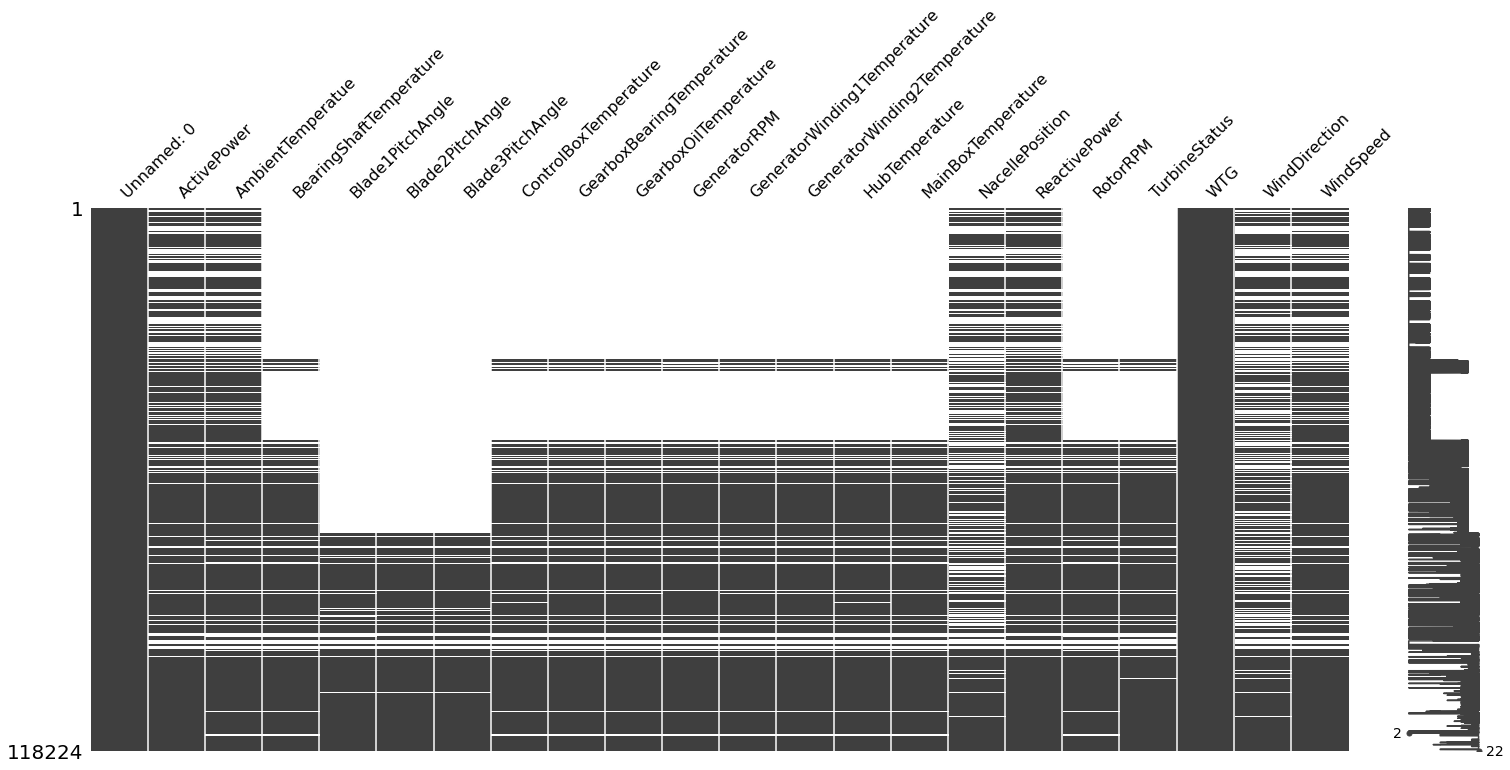

In [62]:
#the dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our LSTM model will not converge or we may end up feeding it with garbage data.
#the rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete. We will strive to use this part for training and testing.
msno.matrix(series)

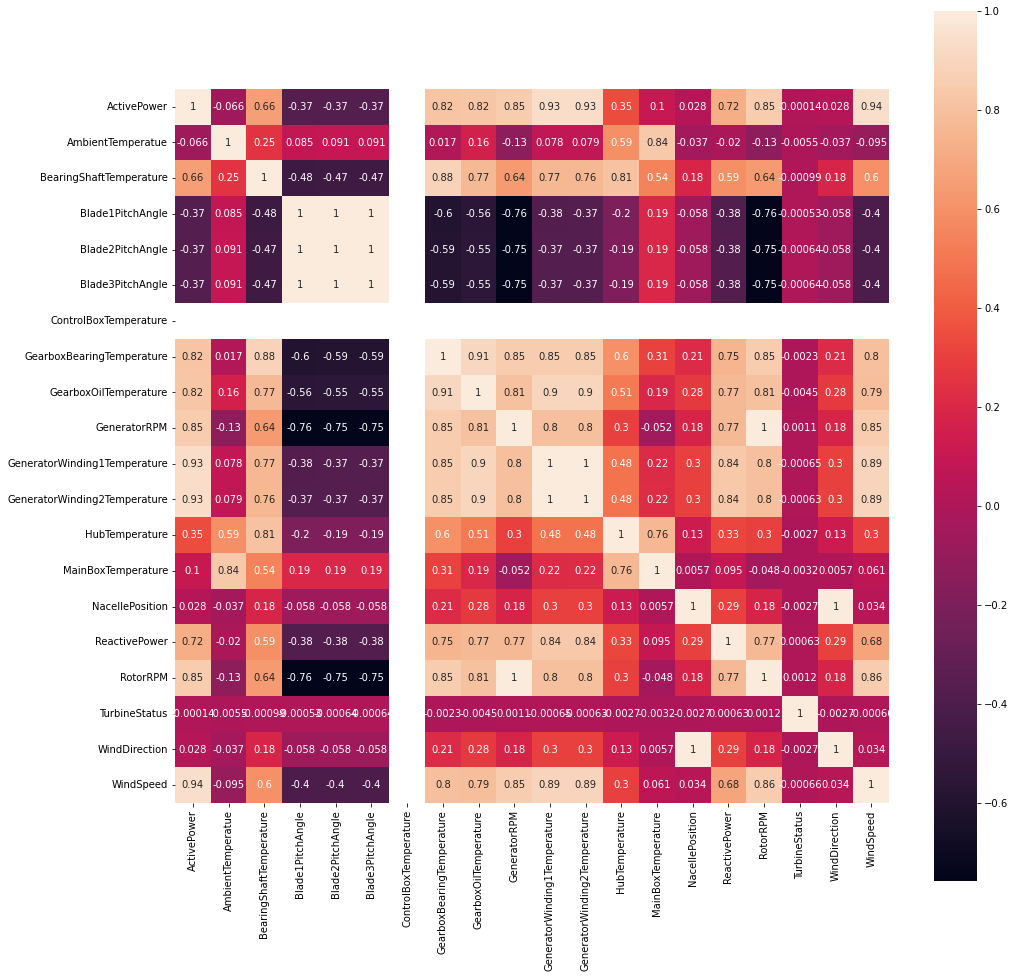

In [63]:
#correlation plot shows high positive correlation between a number of features, which will make them redundant. Discarting these features will help avoid the curse of dimensionality.
#For this demonstration, we will only focus on the Target Y - "ActivePower", and Predictor feature - "WindSpeed". This further simplifies our task.
#If you happen to have the mechanical engineering expertise knowledge about wind turbines, you will know that the wind power out is mostly dependent upon the weather conditions (e.g., wind speed), and you can therefore you can discard the rest of features.
plt.subplots(figsize=(16, 16))
sns.heatmap(series.corr(), annot=True, square=True)
plt.show()

In [64]:
#we select the required data features we will in this demo
#the "unnamed:0" feature is the timestamp
#we will discard the timesetamp feature and then build a new one in a datetime format for the same period with the same time steps
df_selected = series[['Unnamed: 0','ActivePower','WindSpeed']]

In [65]:
#start of dataset is 2017-12-31 00:00:00+00:00
print(df_selected.head())
#end of dataset is 2020-03-30 23:50:00+00:00 
print(df_selected.tail())

                  Unnamed: 0  ActivePower  WindSpeed
0  2017-12-31 00:00:00+00:00          NaN        NaN
1  2017-12-31 00:10:00+00:00          NaN        NaN
2  2017-12-31 00:20:00+00:00          NaN        NaN
3  2017-12-31 00:30:00+00:00          NaN        NaN
4  2017-12-31 00:40:00+00:00          NaN        NaN
                       Unnamed: 0  ActivePower  WindSpeed
118219  2020-03-30 23:10:00+00:00    70.044465   3.533445
118220  2020-03-30 23:20:00+00:00    40.833474   3.261231
118221  2020-03-30 23:30:00+00:00    20.777790   3.331839
118222  2020-03-30 23:40:00+00:00    62.091039   3.284468
118223  2020-03-30 23:50:00+00:00    68.664425   3.475205


# First build a baseline model
The model for baseline we will build will be based on last observations for the same period as the prediction window. This is called a multi-step prediction. E.g. if we want to predict the next 15 days of wind power, we will use the last 15 days of data. It is probably not a great approach, but it only has to serve as a baseline.

In [66]:
#we select the input features
input_df = df_selected[['ActivePower', 'WindSpeed']]

#generate timestamp for the observations mimicking the "unnamed:0" feature
rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)
#fill in missing values with zero using the fillforward function
input_df = input_df.fillna(0).astype(float)
#concatenate both the timestamp range and filled in features
input_df = pd.concat((time_df, input_df), axis=1)
#set up index
input_df = input_df.set_index(0)
#select a subset of data period from second half of original dataset, to ensure we have better quality signal (see completness comment of msno matrix plot above in the code)
input_df = input_df.loc['2019-12-17':]
input_df.head()

,ActivePower,WindSpeed
0,,
2019-12-17 00:00:00,245.469647,4.969920
2019-12-17 00:10:00,246.703719,5.012039
2019-12-17 00:20:00,235.295899,5.015685
2019-12-17 00:30:00,268.555670,5.265058
2019-12-17 00:40:00,188.746578,4.847444


In [67]:
#check for NAN values
input_df.isna().sum()

ActivePower    0
WindSpeed      0
dtype: int64

The dataset is recorded in 10min intervals, meaning 15 days is equivalent to 360 hours, or 2160 steps of 10mins. It is important to understand that a prediction for so many staps ahead is surely to fail, due to accumulation of error with expanding prediction horizon. Furthermore, the forecasting steps are a lot and will make any Neural Network slow down and very slow to converge. Therefore, we will shorten the prediction window to 1 day, or 24hours equal to 144 steps ahead. The code can be easily adjusted to accomodate shorter or longer prediction horizon by chaging the input/output parameters from "144" to the desired output horizon.

RMSE: 271.176


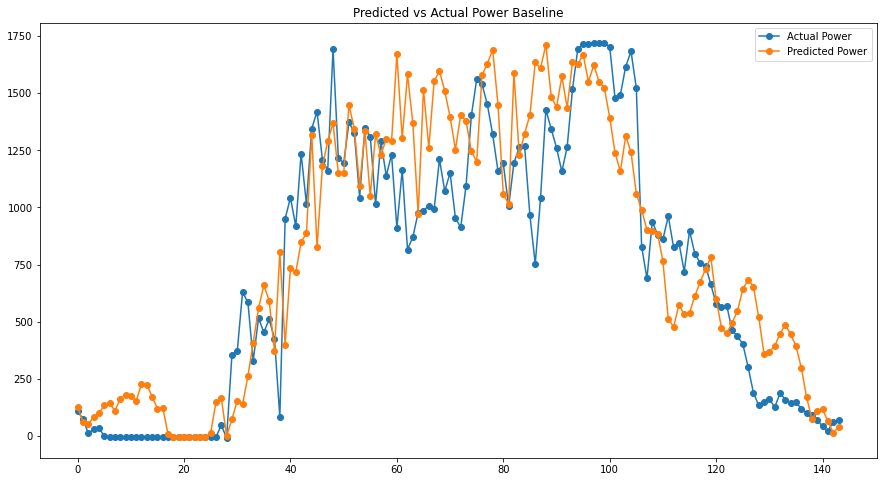

In [68]:
# split data into train and test, for baseline we only need the Y target = "ActivePower" feature
X = input_df['ActivePower'].values
train, test = X[0:-144], X[-144:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-144])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(15, 8))
plt.title('Predicted vs Actual Power Baseline')
plt.plot(test, color='C0', marker='o', label='Actual Power')
plt.plot(predictions, color='C1', marker='o', label='Predicted Power')
plt.legend()
plt.savefig('example.png')
plt.show()

In [69]:
#evaluation metrics
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [70]:
#results from baseline model (some may display "inf" or "nan" due to metric calculation errors such as division by zero)
t = pd.DataFrame(test)
c = pd.DataFrame(predictions)
forecast_accuracy(c, t)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


{'mape': 4.216471949184884,
 'me': 60.36075424339117,
 'mae': 202.76466628697023,
 'mpe': -3.4110376958763604,
 'rmse': 271.1762054984213,
 'corr': nan,
 'minmax': 0.24660027516944494}

# Get data ready for LSTM model

In [71]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#reference: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Set up parameters for input to LSTM network

In [72]:
# Number of lags (steps back in 10min intervals) to use for models
lag = 360
# Steps in future to forecast (steps in 10min intervals)
n_ahead = 144
# ratio of observations for training from total series
train_share = 0.8
# training epochs
epochs = 20
# Batch size , which is the number of samples of lags
batch_size = 512
# Learning rate
lr = 0.001
# The features for the modeling 
features_final = ['ActivePower','WindSpeed']

In [73]:
# Subseting only the needed columns 
ts = input_df[features_final]

Scaling of data. **!Pay attention!** to the shape of input dataset, because after predictions are made the dataset has to be inverse scaled using the same shape.

In [74]:
#Scaling data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(ts)
ts_scaled = scaler.transform(ts)

Creating the X-predictors and Y-target for training

In [75]:
# Creating the X and Y for training, the formula is set up to assume the target Y is the left most column = target_index=0
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [76]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * train_share):], Y[int(X.shape[0] * train_share):]

# Configure the LSTM model

In [77]:
#Neural Network Model configuration, this is a Vanilla LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=False))
#model.add(tf.keras.layers.CuDNNLSTM(32, return_sequences=False)) you can try to use the 10x faster GPU accelerated CuDNNLSTM instaed of the Vanilla LSTM above, but do not forget to set up the notebook accelerator to "GPU"
model.add(tf.keras.layers.Dense(144))

#set up early stop function to stop training when val_loss difference is higher than 0.001
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Epoch 1/20
366/366 [==============================] - 48s 127ms/step - loss: 0.2344 - mae: 0.2344 - val_loss: 0.2438 - val_mae: 0.2438
Epoch 2/20
366/366 [==============================] - 46s 127ms/step - loss: 0.1988 - mae: 0.1988 - val_loss: 0.2354 - val_mae: 0.2354
Epoch 3/20
366/366 [==============================] - 48s 132ms/step - loss: 0.1924 - mae: 0.1924 - val_loss: 0.2242 - val_mae: 0.2242
Epoch 4/20
366/366 [==============================] - 50s 136ms/step - loss: 0.1887 - mae: 0.1887 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 5/20
366/366 [==============================] - 47s 129ms/step - loss: 109.4632 - mae: 109.4632 - val_loss: 0.2228 - val_mae: 0.2228
Epoch 6/20
366/366 [==============================] - 46s 127ms/step - loss: 0.1898 - mae: 0.1898 - val_loss: 0.2199 - val_mae: 0.2199


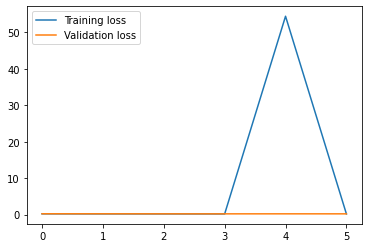

In [78]:
#Train model on train data and use test data for validation
#If the model does not converge accurately, you need check if it is a input data quality issue, introduce a dropout layer, or you can try adjusting the number of hidden nodes
history = model.fit(Xtrain, Ytrain,epochs=epochs, validation_data=(Xtest, Ytest), shuffle=False, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [79]:
#predict based on test data
yhat = model.predict(Xtest)

In [80]:
# Creating the predictions date range
days = time_df.values[-len(yhat):-len(yhat) + n_ahead]
days_df = pd.DataFrame(days)

# Inverse Scale
When doing this inverse scale exercise, it is important to match the shape of data on which the data was used to scale in first place. Otherwise it will throw an incompatible shape error message.

In [81]:
#prepare resulting series for inverse scaling transformation
#pay attention we will select only the first prediction we have made, therefore [0] used to select this window (we have generated multiple prediction sequences of 144 steps ahead, starting from each interval step in the test dataset)
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

#repeat the column series 2 times, to make shape compatible for scale inversion
pr_p = pd.concat([pred_n_ahead]*2, axis=1)
ac_p = pd.concat([actual_n_ahead]*2, axis=1)

In [82]:
#inverse scale tranform the series back to kiloWatts of power
pr_p = pd.DataFrame(scaler.inverse_transform(pr_p))
ac_p = pd.DataFrame(scaler.inverse_transform(ac_p))

#rename columns
pr_p = pr_p.rename(columns={0:'PredPower'})
ac_p = ac_p.rename(columns={0:'ActualPower'})

#concatenate together into one dataframe and set index
df_final = pd.concat([days_df, pr_p['PredPower'], ac_p['ActualPower']], axis=1).set_index(0)

<function matplotlib.pyplot.show(close=None, block=None)>

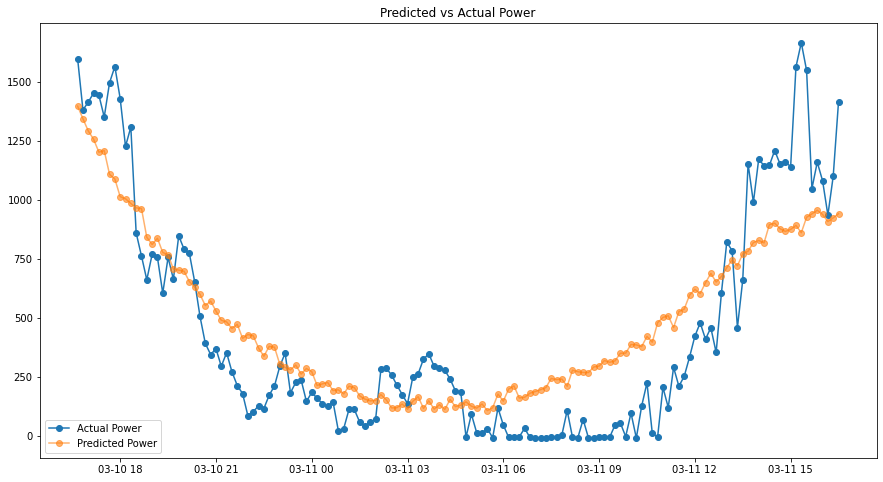

In [83]:
#plot n_steps ahead for predicted and actual data
plt.figure(figsize=(15, 8))
plt.plot(df_final.index, df_final.ActualPower, color='C0', marker='o', label='Actual Power')
plt.plot(df_final.index, df_final.PredPower, color='C1', marker='o', label='Predicted Power', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.savefig('forecast_example.png')
plt.show

Result comments:
1. The algorithm seems to forecast the daily trend somewhat accurately, but it is not precise down to the 10-min intervals. This is explained by the 0.91 correlation coefficient
2. The MAE & RMSE metrics show reduced error for this sequence compared to the one used in the baseline. However, it will be best to do a like for like comparison by using the same forecasting window.
3. The MAPE metric has failed to produce meaningful result
4. The ME metric shows on average we have an overshooting bias of 50kW. So we will forecast we have supply for 50kW more than what we will end up having, this is generally a small error which can be tolerated by grid operators.
5. The algorithm requires more thorough training, turning and testing, to capture the relationship of wind speed and active power
6. For the 15 days ahead a forecasting request, a resampling technique can be used to turn the dataset into hourly steps but this risks losing high quality data points 

In [84]:
#evaluate result
forecast_accuracy(df_final['PredPower'], df_final['ActualPower'], )

{'mape': 8.166608603005644,
 'me': 42.62057806093019,
 'mae': 196.08499869081624,
 'mpe': -4.940596302434025,
 'rmse': 234.50374789583248,
 'corr': 0.9062317727749608,
 'minmax': 0.4796933638268722}

In [85]:
##residuals summary stats
df_final['Residuals'] =  df_final['PredPower'] - df_final['ActualPower']
df_final['Residuals'].describe()

count    144.000000
mean      42.620578
std      231.403005
min     -804.778525
25%     -107.921822
50%       97.697522
75%      207.957271
max      484.151400
Name: Residuals, dtype: float64

Text(0, 0.5, 'Occurance count')

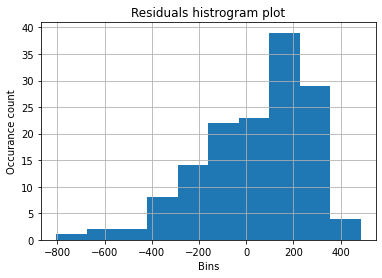

In [86]:
#residuals histogram shows the bias (Mean Error)
df_final['Residuals'].hist(color = ('C0'))
plt.title('Residuals histrogram plot')
plt.xlabel('Bins')
plt.ylabel('Occurance count')

<AxesSubplot:ylabel='Density'>

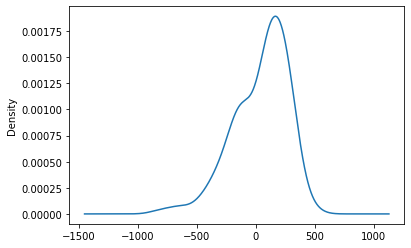

In [87]:
#density plot shows the bias (Mean Error)
df_final['Residuals'].plot(kind='kde')

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


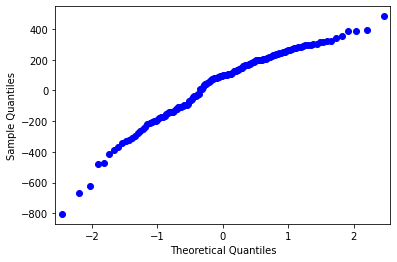

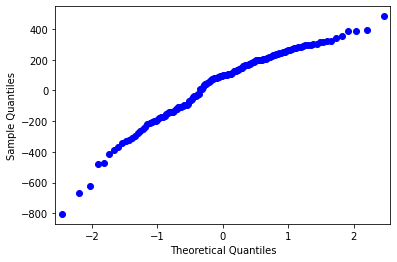

In [88]:
#Q-Q plot showing normal distrubition of data
from statsmodels.graphics.gofplots import qqplot
qqplot(df_final['Residuals'])

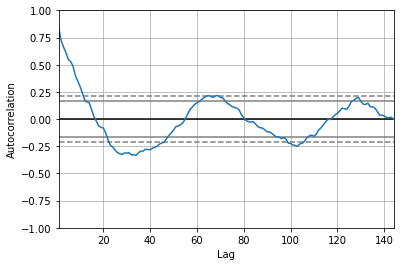

In [89]:
#autocorrelation (excursions from the boundry lines) show that the model is doing a good job of incorporating relationship between observtations and lagged overvations
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_final['Residuals'])
plt.show()